분류 성능비교
==

다루는 내용
--
- 분류 알고리즘 비교
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

데이터
--
- 포도주 품질 분류 https://goo.gl/Gyc8K7

출처
--
https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine/notebook



모듈 불러오기
--

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier <- pip install xgboost
from sklearn.svm import SVC
from sklearn.svm import SVR # Support Vector Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

데이터 읽기 (포도주 품질 평가)
--

In [3]:
wine = pd.read_csv('data/winequality-red.csv')
# 데이터 사본 https://goo.gl/m3eCrf

In [4]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wine.shape

(1599, 12)

- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [6]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 여러 특성 한번에 보기 (박스 플롯)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, 'fixed acidity'),
  Text(2, 0, 'volatile acidity'),
  Text(3, 0, 'citric acid'),
  Text(4, 0, 'residual sugar'),
  Text(5, 0, 'chlorides'),
  Text(6, 0, 'free sulfur dioxide'),
  Text(7, 0, 'total sulfur dioxide'),
  Text(8, 0, 'density'),
  Text(9, 0, 'pH'),
  Text(10, 0, 'sulphates'),
  Text(11, 0, 'alcohol'),
  Text(12, 0, 'quality')])

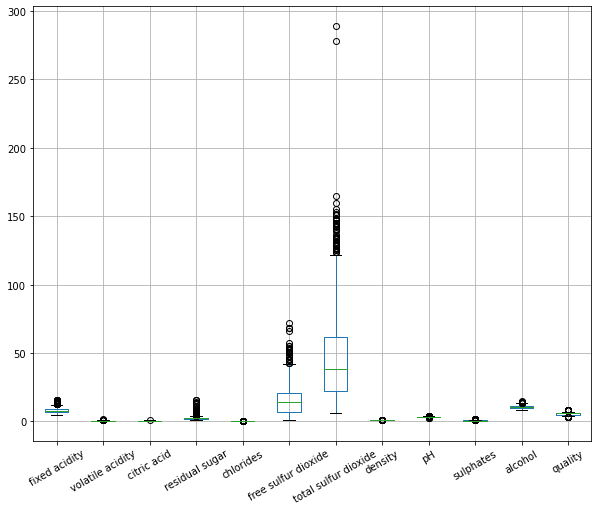

In [8]:
#맨처음에 박스플롯을 그린다 거의 한눈에 다보여주기 때문에
wine.boxplot(figsize = (10,8))
plt.xticks(rotation=30)

줄여서 보기
--

<AxesSubplot:>

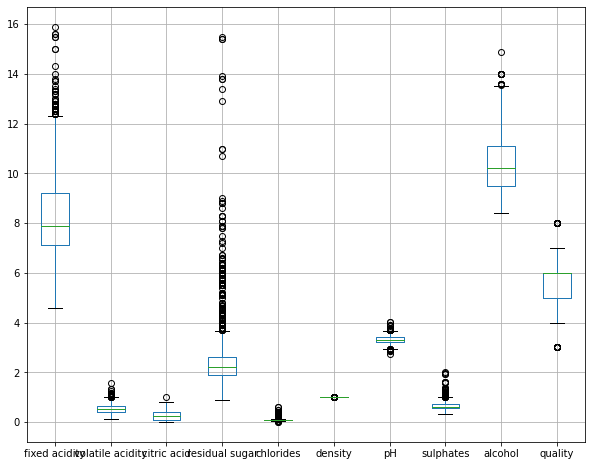

In [9]:
#위에서 크게나온 그림 빼고 다시그림 다른것들을 자세히 보기위해서
wine.drop(['free sulfur dioxide', 'total sulfur dioxide'], axis=1).boxplot(figsize = (10,8))

In [10]:
wine[['alcohol', 'quality']].head(10)

,alcohol,quality
0,9.4,5
1,9.8,5
2,9.8,5
3,9.8,6
4,9.4,5
5,9.4,5
6,9.4,5
7,10.0,7
8,9.5,7
9,10.5,5


<AxesSubplot:>

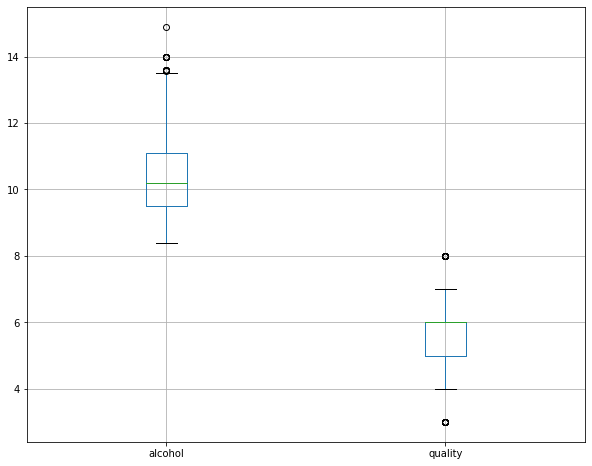

In [11]:
wine[['alcohol', 'quality']].boxplot(figsize = (10,8))

히스토그램
--

array([[<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

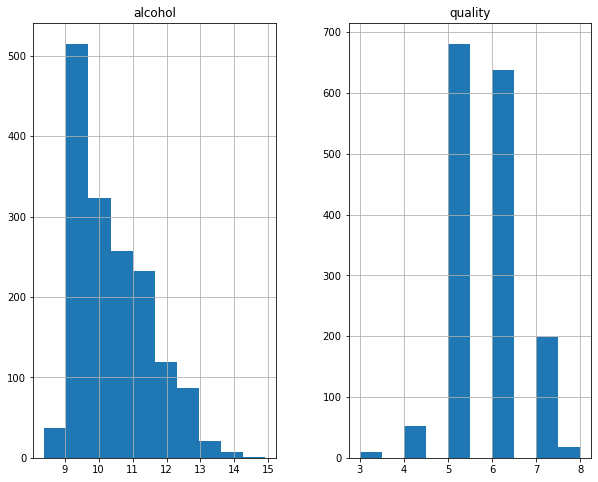

In [12]:
wine[['alcohol', 'quality']].hist(figsize = (10,8))

품질관련 데이터 파악
--

<AxesSubplot:title={'center':'alcohol'}, xlabel='[quality]'>

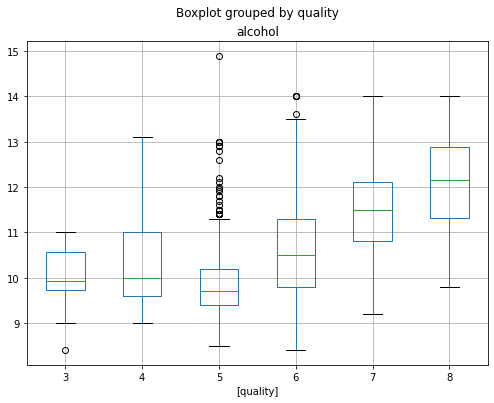

In [13]:
#퀄리티가 3인것만 모아서 그리고 4만모아서 그리고...
wine[['alcohol', 'quality']].boxplot(by='quality',figsize = (8,6)) # by값 - 기준
#quality가 좋은건 평균적으로 알코올 성분이 좋다.
#포도주도 알코올이 있는것들을 좋아함

array([<AxesSubplot:title={'center':'chlorides'}, xlabel='[quality]'>,
       <AxesSubplot:title={'center':'citric acid'}, xlabel='[quality]'>],
      dtype=object)

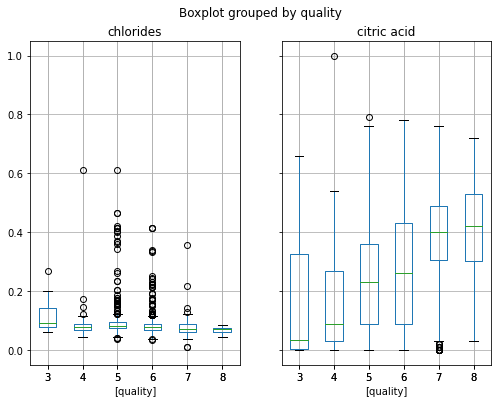

In [14]:
#chlorides : 염화물 , citric acid : 시트르산
wine1 = wine[[ 'chlorides', 'citric acid', 'quality']]
wine1.boxplot(by='quality',figsize = (8,6))

array([[<AxesSubplot:title={'center':'alcohol'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'chlorides'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'citric acid'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'density'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'fixed acidity'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'pH'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'residual sugar'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'sulphates'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'volatile acidity'}, xlabel='[quality]'>,
        <AxesSubplot:>]], dtype=object)

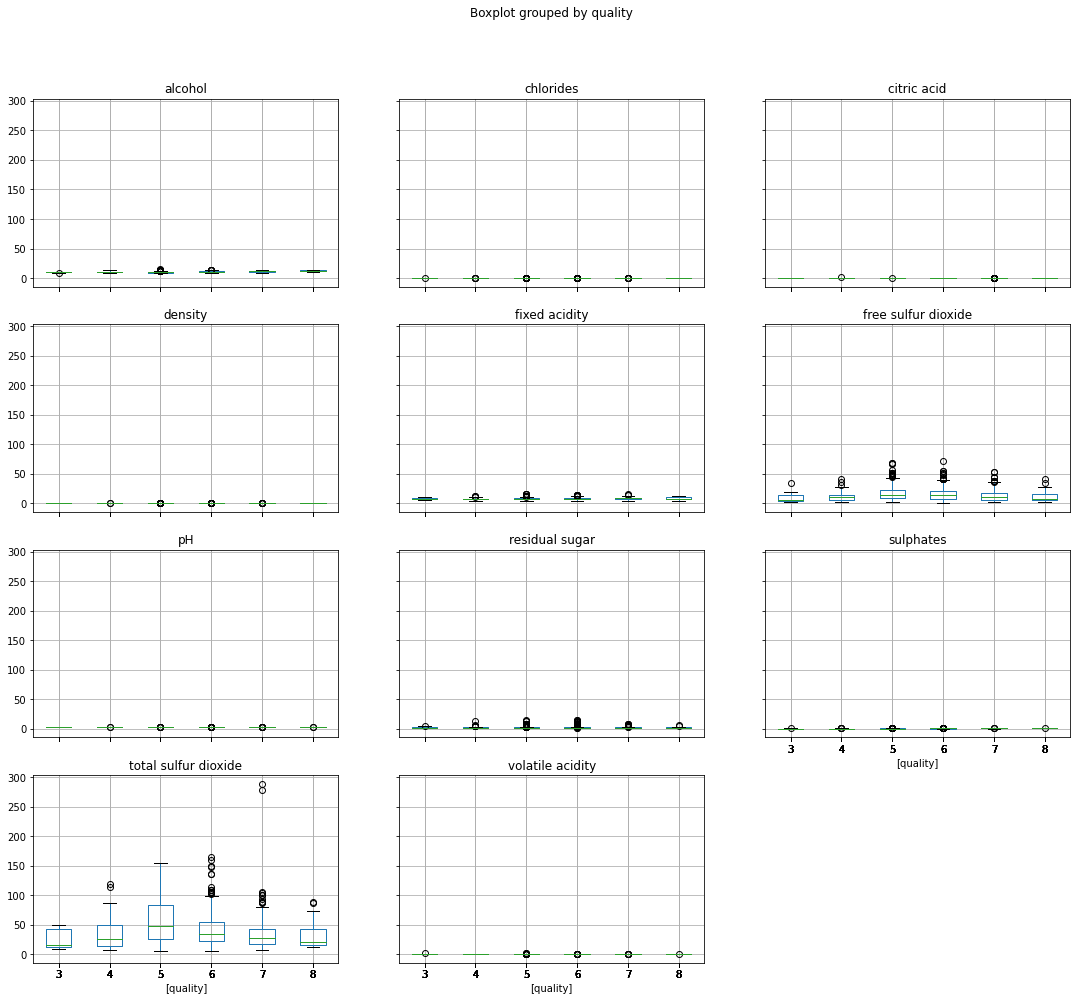

In [15]:
wine.boxplot(by='quality',figsize = (18,16))

array([[<AxesSubplot:title={'center':'alcohol'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'chlorides'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'citric acid'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'density'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'fixed acidity'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'pH'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'residual sugar'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'sulphates'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'volatile acidity'}, xlabel='[quality]'>]],
      dtype=object)

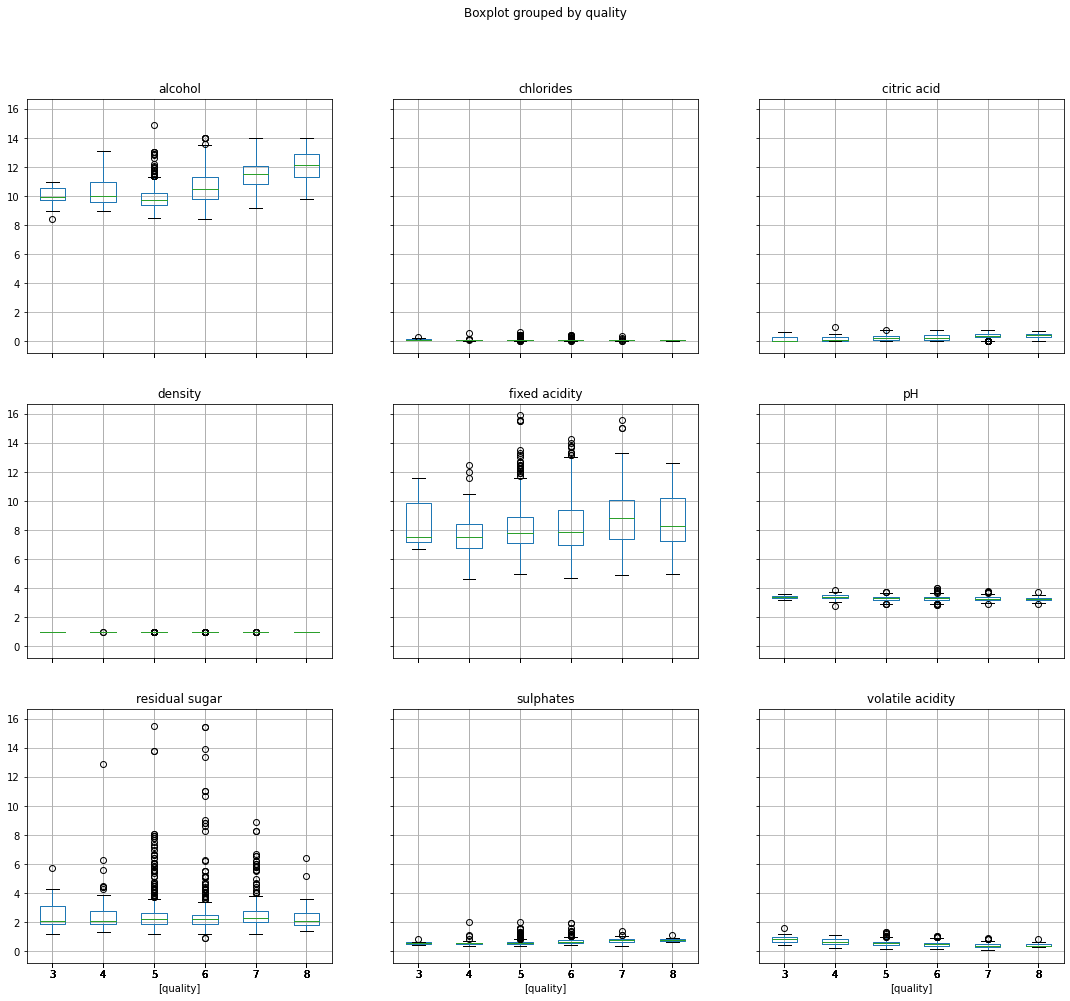

In [16]:
wine.drop(['free sulfur dioxide', 'total sulfur dioxide'], axis=1).boxplot(by='quality',figsize = (18,16))

array([[<AxesSubplot:title={'center':'chlorides'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'citric acid'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'density'}, xlabel='[quality]'>,
        <AxesSubplot:title={'center':'sulphates'}, xlabel='[quality]'>],
       [<AxesSubplot:title={'center':'volatile acidity'}, xlabel='[quality]'>,
        <AxesSubplot:>]], dtype=object)

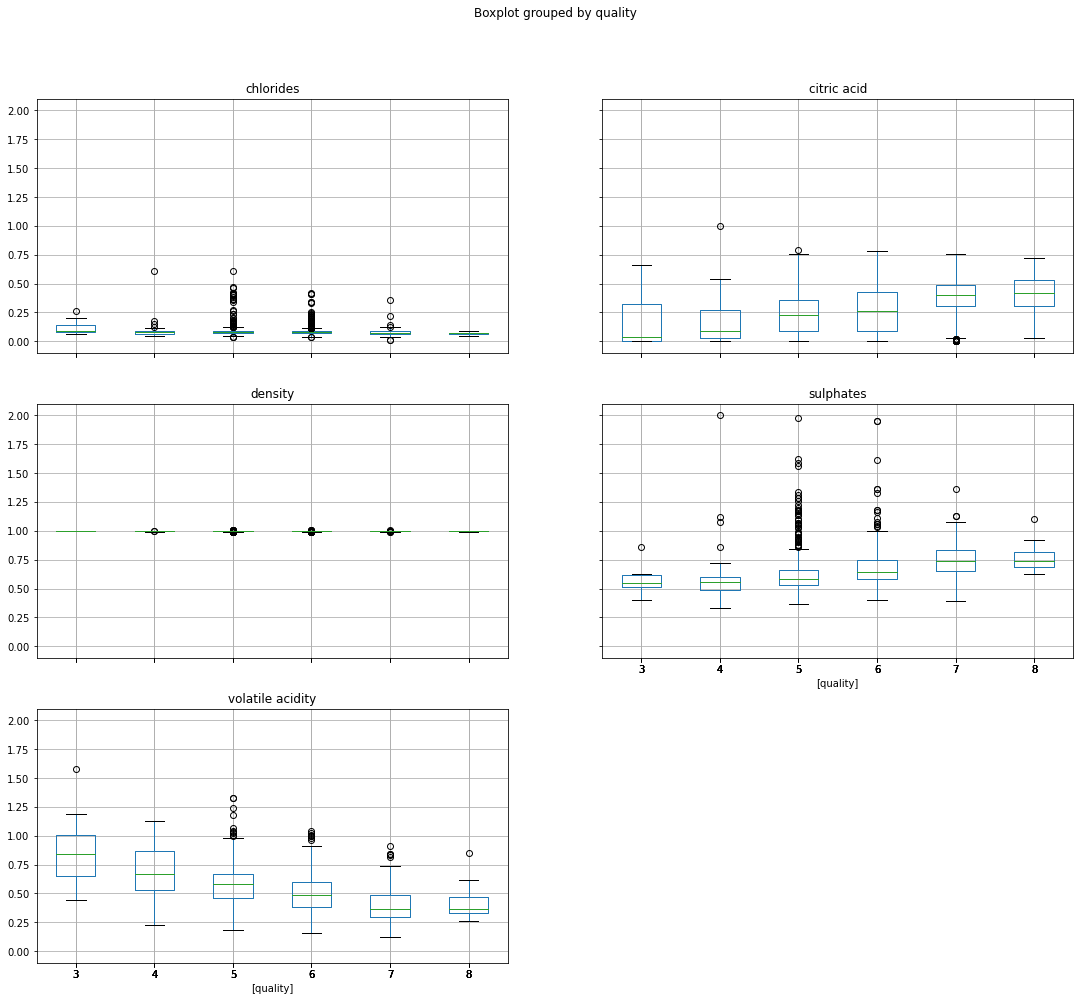

In [17]:
wine.drop(['free sulfur dioxide', 'total sulfur dioxide','alcohol','fixed acidity','residual sugar','pH'], axis=1).boxplot(by='quality',figsize = (18,16))

## 데이터 전처리 (레이블 만들기)

In [18]:
wine['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [19]:
wine.quality.unique() 

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [20]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [21]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
bins = (2.9, 6.5, 8.1)#bins 구간을 나눌때 쓴다.(마지막에 8을썼더니 컴퓨터나 8을 뺴버렸다. 그래서 8을 포함시키기 위해 안전하게 8.1을 사용)
#8만 잡게하면 성능이 좋아진다.
group_names = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = bins, labels = group_names) #cut 함수 2.9 초과 6.5 이하, 6.5 초과 8.1 이하로 범위를 나눠줌

In [22]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,qual
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [23]:
wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [24]:
# 예측변수와 레이블을 나눈다
# X 데이터에서는 'quality'와 'qual' 컬럼 제거
# y는 레이블만 담는다

X_new = wine.drop(['quality', 'qual'], axis = 1)
y_ = wine['quality'] # regression 용
y = wine['qual'] 

In [25]:
X_new.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [26]:
y.value_counts()

0    1382
1     217
Name: qual, dtype: int64

표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [27]:
sc = StandardScaler()
X = sc.fit_transform(X_new)
#fit을 하고 transform을 한번에 한것, 코드를 줄여주기 위해서
#fit은 데이터를 읽고 평균과 시그마를 구한다. (하나의 모델을 만듬, 여기에 들어가는 파라미터가 평균과 시그마) -> 스케일링 하기위한 상수구하기
#transform은 실제 값들을 넣어서 나오는 값들

#원래는 데이터를 자체적으로 나눠서 cross valredation을 해야한다. 하지만 지금은 통으로했다.

In [28]:
# 데이터 프레임에 스케일링 연산을 하면 ndarray로 바뀐다
X[:5]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711],
       [ 1.65485608, -1.38444349,  1.4841536 , -0.45321841, -0.26496041,
         0.10759209,  0.41150046,  0.6642772 , -0.97910442, -0.46118037,
        -0.58477711],
       [-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [29]:
X.sum()

-4.860112312599085e-11

In [30]:
# 데이터를 랜덤하게 섞은 후 80%를 훈련데이터로 사용
# random_state 같은 값으로 지정하면 랜덤하게 섞이는 순서가 같다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7) # 분류용
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y_, test_size = 0.2, random_state = 7) # 회귀용

#직접 실습을 해보는데 지금은 80%이지만 다르게 할 수도 있다.
#위에 모델을 바꿔서 6.5가 맛있다가 아니라 8만 맛있다 등 바꿔본다.

In [31]:
X_train.shape, y_train.shape

((1279, 11), (1279,))

In [32]:
X_test.shape, y_test.shape

((320, 11), (320,))

# 1. 분류

## KNN(K-최근접 이웃)

In [33]:
clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.8875

결정 트리 (Decesion Tree)
--

In [34]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.84375

## 랜덤 포래스트 (Random Forest Classifier)

In [35]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=300) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.890625

## 그라디언트 부스팅 (Gradient Boosting Classifier)

In [36]:
GBC = GradientBoostingClassifier(max_depth=5, n_estimators=100, learning_rate=0.1, random_state=42)
GBC.fit(X_train, y_train)
GBC.score(X_test,y_test)

0.884375

##  정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [37]:
pred_rfc = rfc.predict(X_test)
confusion_matrix(y_test, pred_rfc)
# RandomForest에 대한 confusion_matrix

array([[267,  12],
       [ 23,  18]], dtype=int64)

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [38]:
# 여러 성능 지표를 출력한다
print(classification_report(y_test, pred_rfc))
#밑에 숫자는 0을 기준으로 0.94 맞춤 
#pos 긍정이 아닌 내가 찾고자 하는 답을 pos라고 봄(암환자)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       279
           1       0.60      0.44      0.51        41

    accuracy                           0.89       320
   macro avg       0.76      0.70      0.72       320
weighted avg       0.88      0.89      0.88       320



- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

## Support Vector Classifier (SVC)

In [39]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.8875

Logistic Regression
--

In [40]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

0.88125

## Cross validation(교차 검증)

In [41]:
#rfc 랜덤포레스트 모델 위에 변수로 선언해줌(제일 잘나와서)
# estimator = 모델, cv는 분할 테스트 숫자
rfc_eval = cross_val_score(rfc, X = X, y = y, cv = 5)  
rfc_eval  # 5번의 교차 검증 결과를 보여준다

array([0.875     , 0.859375  , 0.884375  , 0.8625    , 0.87460815])

In [42]:
rfc_eval.mean()

0.871171630094044

Percentile Test
==

분류 성능 평가 (정적)
--

In [43]:
from itertools import cycle
from sklearn import svm, datasets
import sklearn.metrics 
from sklearn.preprocessing import label_binarize
from scipy import interp

In [44]:
X.shape, y.shape

((1599, 11), (1599,))

선형모델
--

In [45]:
classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).decision_function(X_test)#decision_function() 어떤 클래스라고 분류한 확률을 리턴해줌
print(classifier.score(X_test, y_test))
y_score

0.88125


array([-3.23255167, -2.60233669, -2.26384094, -3.94927445, -1.63139858,
       -2.74552105, -3.29705645,  0.2567037 , -4.07650613, -4.08446571,
       -1.08469593,  0.58530779,  1.46178775, -4.1082072 , -4.30123362,
       -5.18069522, -1.62667503, -4.62032354, -2.71851477, -1.81475938,
       -3.25825878, -4.29095409, -4.1835576 , -2.18205554, -3.79229494,
       -0.88288943, -3.76914463, -4.59798655, -0.71044743, -4.85370834,
       -2.05680241, -4.720215  , -3.01881312, -2.98387642, -4.48072553,
       -5.22919861,  0.08368432, -4.53964406, -1.43822348, -3.95182913,
       -3.49055513, -0.84546188, -1.43134174, -2.55042925, -1.18409326,
       -2.73620393, -2.25300701, -1.45936052, -1.32629689,  0.77100023,
       -1.08973161, -4.01925955,  0.15863176,  0.66576669, -2.54954665,
       -1.7733088 , -0.74559724, -2.77983295, -4.5028414 ,  2.07590583,
       -3.62250652, -0.47198932, -0.9683275 , -4.45531197, -3.74507774,
       -4.68708046, -1.15314063, -2.59162119, -1.93083718, -1.29

ROC로 성능 평가 (맞춘 순서를 평가)
--

In [46]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#roc_auc는 그래프의 넓이를 구한다. 초반에 빨리 올라가면 면적이 넓다.
#가장 낮은건 평균인 0.5, 최대는 1이 된다.
roc_auc

0.888888888888889

# ROC그림 실습해보기

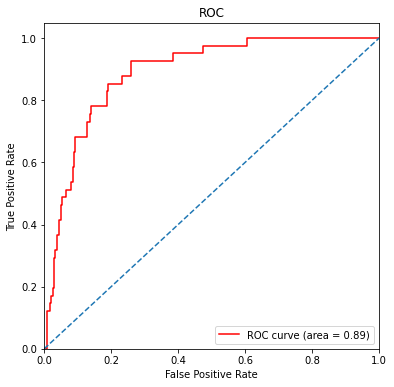

In [47]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# 2. 회귀

In [48]:
def rmse(true,pred):
    return np.sqrt(mean_squared_error(true,pred))

metrics = {'MSE': mean_squared_error,
              'RMSE': mean_absolute_error,
              'MAE': rmse,
              'R2': r2_score}

def linear_eval(model):
    for i in metrics.keys():
        print(f'{i} : {metrics[i](y_test_, model.predict(X_test_))}')

## 선형 모델

In [49]:
lr = LinearRegression()
lr.fit(X_train_, y_train_)
linear_eval(lr)

MSE : 0.3795971085022979
RMSE : 0.48139673183329795
MAE : 0.6161145254758225
R2 : 0.3468858137200871


In [50]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train_, y_train_)
linear_eval(ridge)

MSE : 0.37959704061469146
RMSE : 0.48139670587277317
MAE : 0.6161144703824862
R2 : 0.34688593052381866


In [51]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_, y_train_)
linear_eval(lasso)

MSE : 0.3784675443075926
RMSE : 0.48126911706022313
MAE : 0.6151971588910279
R2 : 0.34882928057837415


## Support Vector Regressor(SVR)

In [52]:
svr = SVR(kernel='rbf',gamma='auto',C=1, epsilon=0.1)
svr.fit(X_train_, y_train_)
linear_eval(svr)

MSE : 0.3343751871308257
RMSE : 0.4293437239999129
MAE : 0.5782518371184182
R2 : 0.42469219769143507
